In [18]:
from importlib import reload

import GPRutils
import vK2KGPR
import plotGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')

In [19]:
exp = 476846
dC = GPRutils.loadNPZ(f"../thesis/{exp}/{exp}.npz")

In [20]:
x, y = dC.Xvalid.T*u.deg
dx, dy = dC.Yvalid.T*u.mas
err = np.sqrt(dC.Evalid_DES)*u.mas

x2, y2 = x, y
dx2, dy2 = dC.Yvalid.T*u.mas - dC.fbar_s.T*u.mas
err2 = err

In [21]:
rmax = 0.5*u.deg
nBins = 75

nData = len(x)
if nBins % 2 == 0:
    nBins += 1
bins = np.around(np.linspace(-rmax, rmax, nBins).to(u.arcmin), 1).value
ticks = np.array([
    nBins//7, nBins//3,
    nBins//2,
    nBins-nBins//3-1, nBins-nBins//7-1
])
ticklabels = bins[ticks]

In [22]:
xiplus = GPRutils.calcCorrelation2D(
    x, y, dx, dy, rmax=rmax, nBins=nBins)[0]

xiplus2 = GPRutils.calcCorrelation2D(
    x2, y2, dx2, dy2, rmax=rmax, nBins=nBins)[0]

In [23]:
dx = (rmax / (nBins / 2)).to(u.deg).value
x = np.arange(-nBins / 2, nBins / 2) * dx
xx, yy = np.meshgrid(x, x)

ttt = vk.TurbulentLayer(
    variance=dC.params[0],
    outerScale=dC.params[1],
    diameter=dC.params[2],
    wind=(dC.params[3], dC.params[4]))

Cuv = ttt.getCuv(xx, yy)
xiplus_model = Cuv[:, :, 0, 0] + Cuv[:, :, 1, 1]
xiplus_model = np.where(np.isnan(xiplus_model), 0, xiplus_model)

/home/fortino/DESworkspace/vonkarmanFT.py:65: RuntimeWarning: divide by zero encountered in true_divide
  airy = (j1(kR)/(kR))**2
/home/fortino/DESworkspace/vonkarmanFT.py:65: RuntimeWarning: invalid value encountered in true_divide
  airy = (j1(kR)/(kR))**2
/home/fortino/DESworkspace/vonkarmanFT.py:75: RuntimeWarning: divide by zero encountered in true_divide
  w = np.where(kWind==0, 1., np.sin(kWind) / kWind)
/home/fortino/DESworkspace/vonkarmanFT.py:75: RuntimeWarning: invalid value encountered in true_divide
  w = np.where(kWind==0, 1., np.sin(kWind) / kWind)


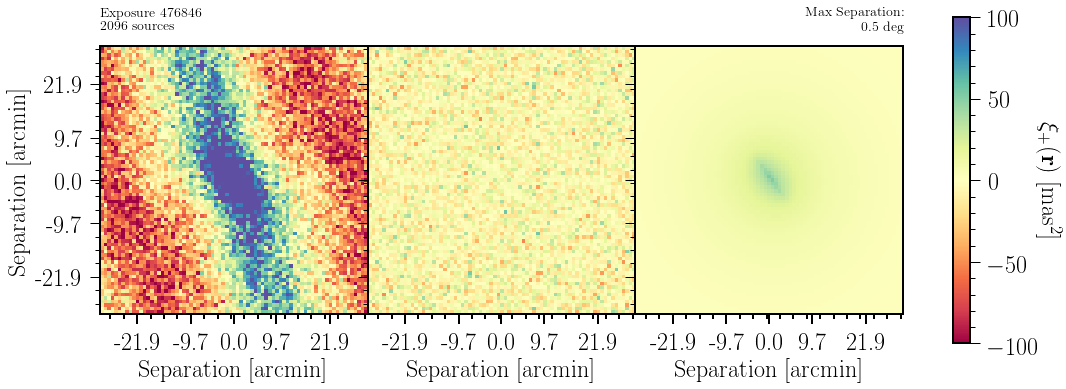

In [30]:
vmin = -100*u.mas**2
vmax = 100*u.mas**2

fig, axes = plt.subplots(
    nrows=1, ncols=3,
    sharex=True, sharey=True,
    figsize=(18, 6))
fig.subplots_adjust(wspace=0)

plt.text(0.125, 0.88, f"Exposure {exp}",
         transform=fig.transFigure,
         ha="left")
plt.text(0.125, 0.85, f"{nData} sources",
         transform=fig.transFigure,
         ha="left")
plt.text(0.745, 0.85, f"Max Separation:\n{rmax}",
         transform=fig.transFigure,
         ha="right")

axes[0].set_ylabel("Separation [arcmin]")
axes[0].set_xlabel("Separation [arcmin]")
axes[1].set_xlabel("Separation [arcmin]")
axes[2].set_xlabel("Separation [arcmin]")

im1 = axes[0].imshow(
    xiplus,
    origin="Lower",
    cmap="Spectral",
    interpolation="nearest",
    vmin=vmin.to(u.mas**2).value,
    vmax=vmax.to(u.mas**2).value)

im2 = axes[1].imshow(
    xiplus2,
    origin="Lower",
    cmap="Spectral",
    interpolation="nearest",
    vmin=vmin.to(u.mas**2).value,
    vmax=vmax.to(u.mas**2).value)

im3 = axes[2].imshow(
    xiplus_model,
    origin="Lower",
    cmap="Spectral",
    interpolation="nearest",
    vmin=vmin.to(u.mas**2).value,
    vmax=vmax.to(u.mas**2).value)

axes[0].set_yticklabels(ticklabels)
axes[0].set_xticklabels(ticklabels)
axes[0].set_yticks(ticks)
axes[0].set_xticks(ticks)

cbar = fig.colorbar(im1, ax=fig.get_axes())
cbar.set_label(
    r"$\xi_+(\textbf{r})$ [mas$^2$]",
    rotation=270,
    labelpad=20,
)

plt.savefig("thesis_plots/2dxi.pdf")
plt.show()